In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from datetime import date, datetime, timedelta
import pytz
import seaborn as sns
from itertools import combinations

In [2]:
#initial inputs
stock_list = ['AAPL', 'MSFT', 'GOOG','AMZN']
start_date, end_date = '2010-01-01', '2022-12-31'

In [3]:
#functions to source new data
def get_stock_data(ticker,start_date,end_date):
    stock_data = yf.Ticker(ticker).history(start=start_date,end=end_date).reset_index()
    return stock_data

def get_sp500(start_date,end_date):
    sp500_data = yf.Ticker("^GSPC").history(start=start_date, end=end_date).reset_index()
    return sp500_data

In [4]:
#ingest data and do preliminary data cleansing

stock_dict = {}
ma_day = [20,50,100]

for stock in stock_list:
    get_stock_data(stock, start_date, end_date).to_csv(stock + ".csv",index=False)
    stock_dict[stock] = dict()
    stock_dict[stock]['data'] = pd.read_csv(stock + '.csv')
    stock_dict[stock]['data']['Ticker'] = stock
    stock_dict[stock]['data']['Date'] = stock_dict[stock]['data']['Date'].apply(lambda x: datetime.fromisoformat(x).astimezone(pytz.utc).date())

    #calculated moving average stock prices
    for ma in ma_day:
        var_name = f"{ma}-day MA Close"
        stock_dict[stock]['data'][var_name] = stock_dict[stock]['data']['Close'].rolling(ma).mean()
        
    #calculate daily percentage change (i.e., daily return)
    stock_dict[stock]['data']['Daily Return'] = stock_dict[stock]['data']['Close'].pct_change()
    

In [5]:
stock_dict['AAPL']['data'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,20-day MA Close,50-day MA Close,100-day MA Close,Daily Return
0,2010-01-04,6.478688,6.511168,6.446815,6.496294,493729600,0.0,0.0,AAPL,NaN,NaN,NaN,NaN
1,2010-01-05,6.514205,6.544257,6.473225,6.507527,601904800,0.0,0.0,AAPL,NaN,NaN,NaN,0.001729
2,2010-01-06,6.507526,6.533328,6.397337,6.404015,552160000,0.0,0.0,AAPL,NaN,NaN,NaN,-0.015906
3,2010-01-07,6.427692,6.435280,6.345733,6.392176,477131200,0.0,0.0,AAPL,NaN,NaN,NaN,-0.001849
4,2010-01-08,6.383678,6.435282,6.346039,6.434675,447610800,0.0,0.0,AAPL,NaN,NaN,NaN,0.006649


In [6]:
stock_dict['AAPL']['data'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              3272 non-null   object 
 1   Open              3272 non-null   float64
 2   High              3272 non-null   float64
 3   Low               3272 non-null   float64
 4   Close             3272 non-null   float64
 5   Volume            3272 non-null   int64  
 6   Dividends         3272 non-null   float64
 7   Stock Splits      3272 non-null   float64
 8   Ticker            3272 non-null   object 
 9   20-day MA Close   3253 non-null   float64
 10  50-day MA Close   3223 non-null   float64
 11  100-day MA Close  3173 non-null   float64
 12  Daily Return      3271 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 332.4+ KB


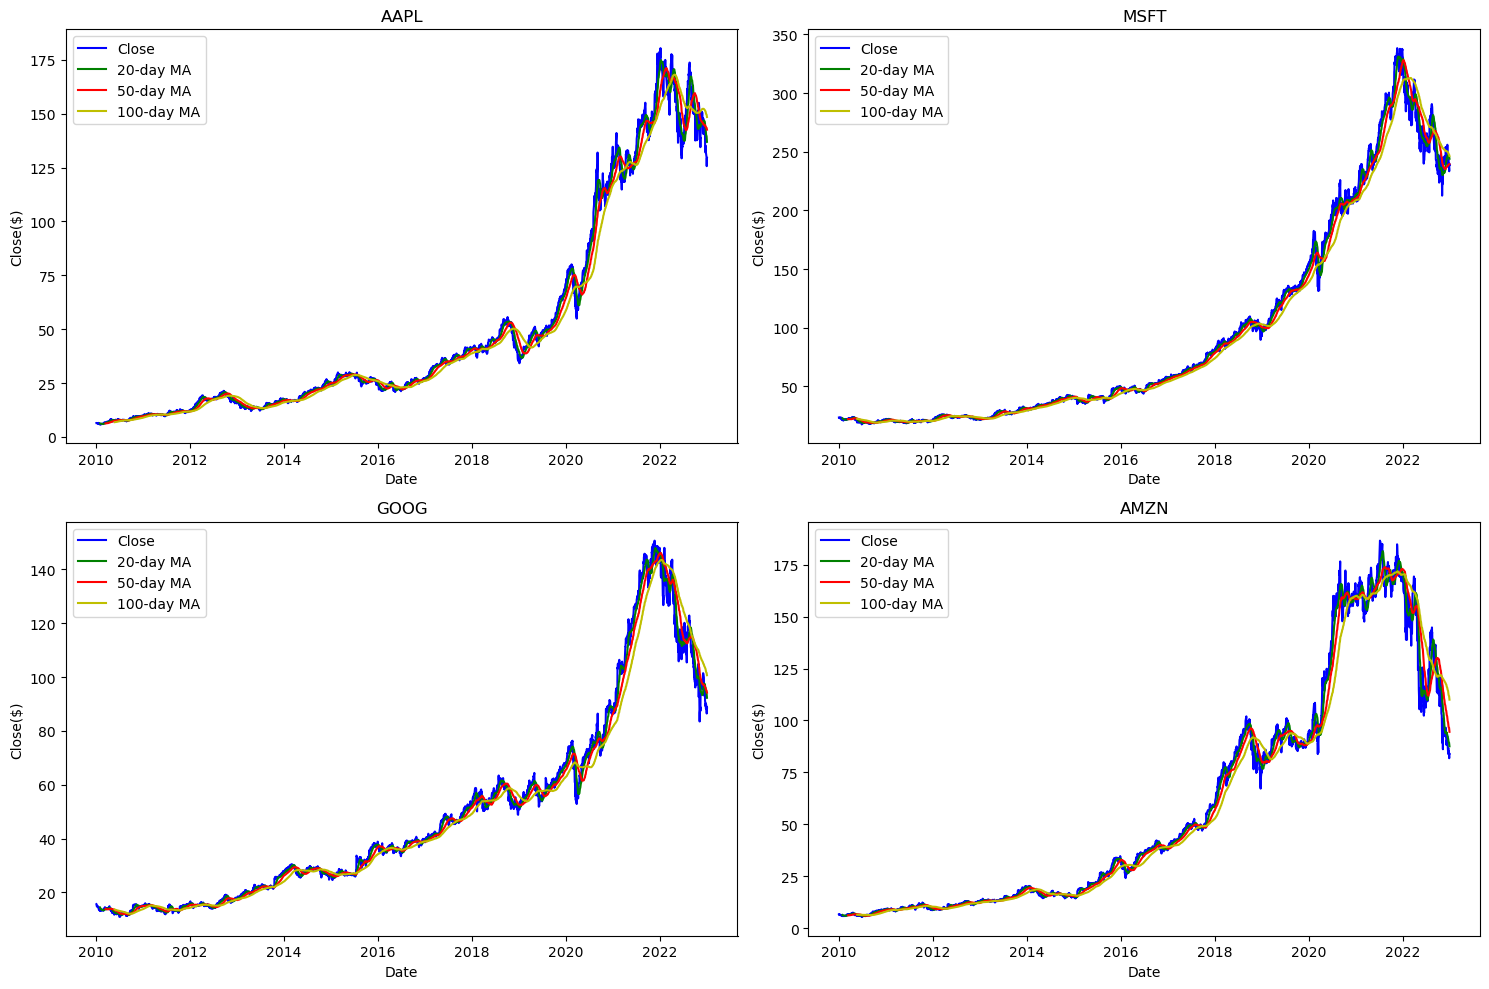

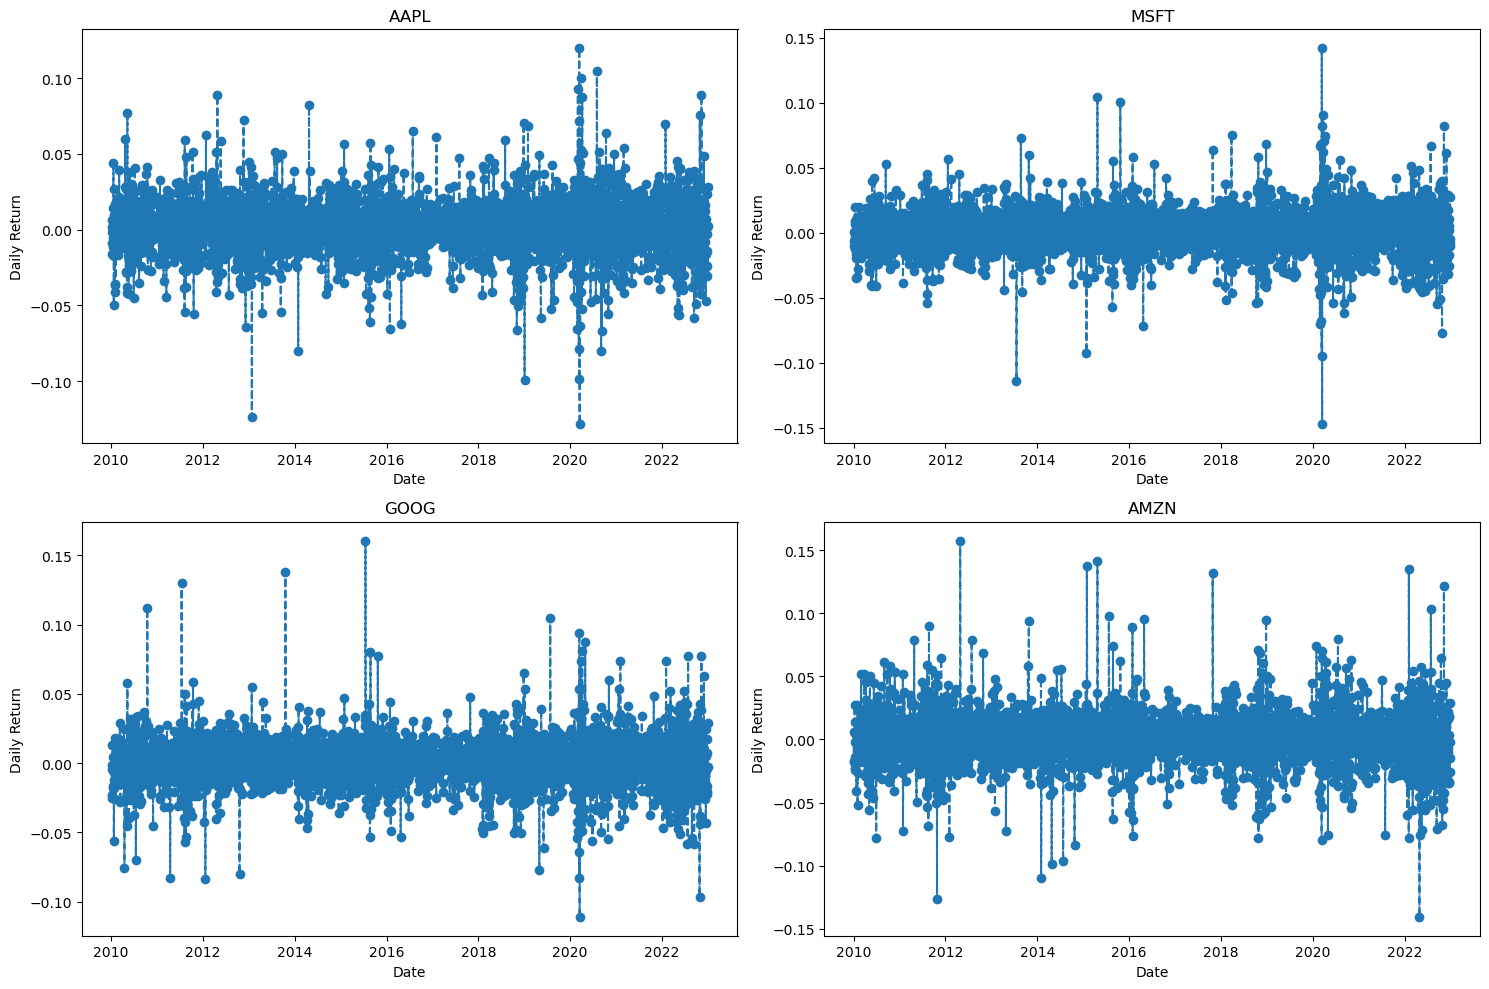

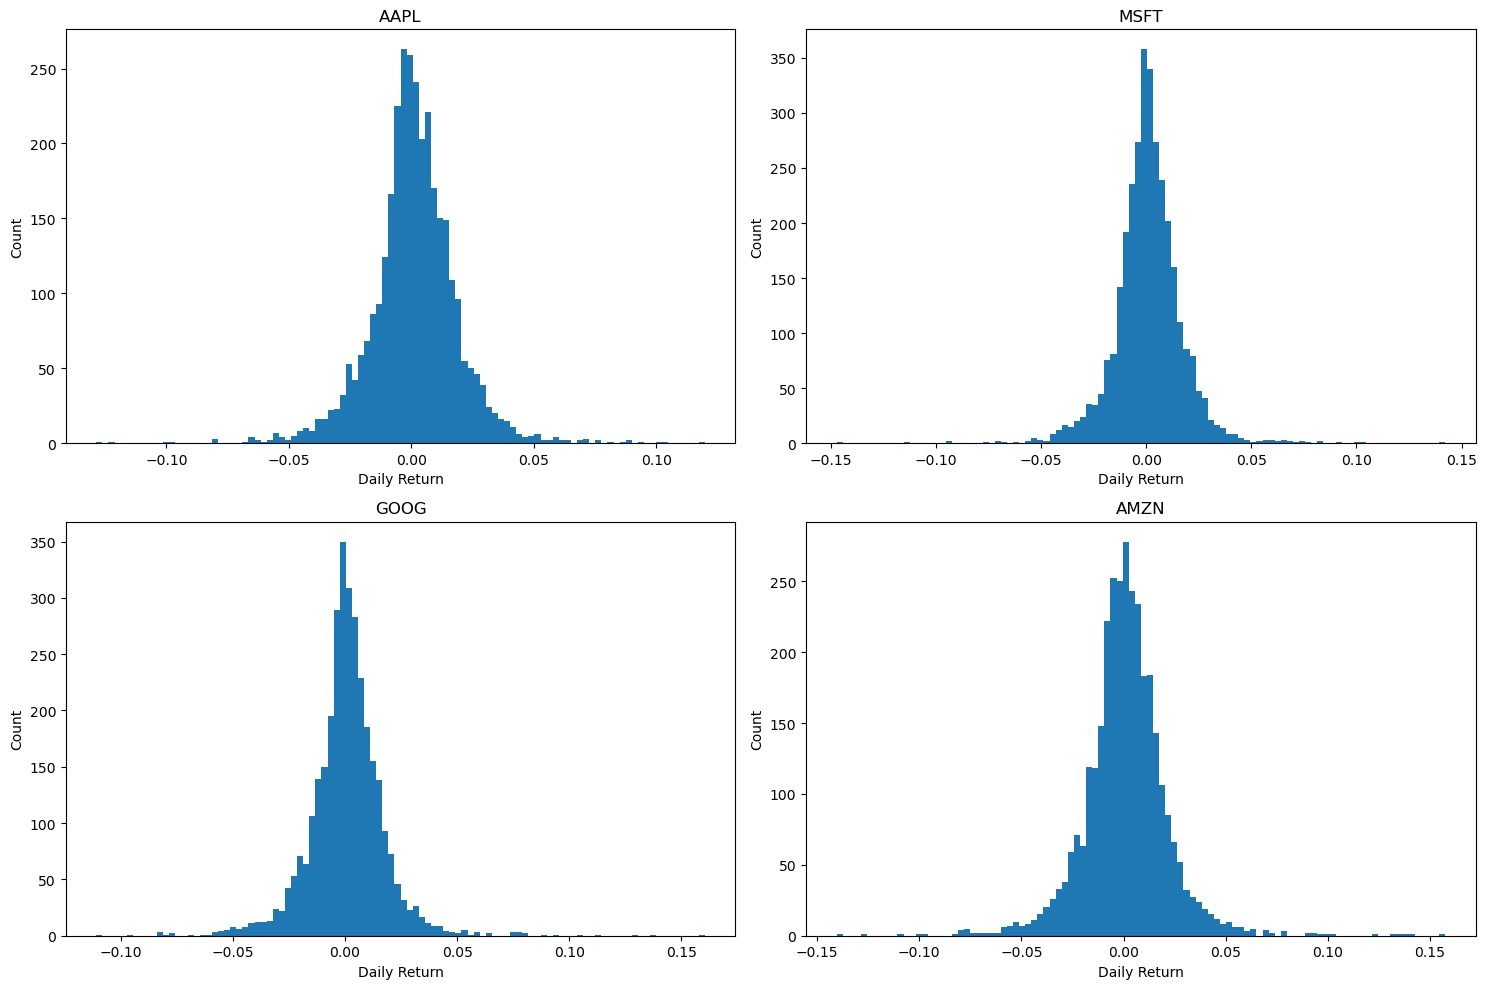

In [7]:
#plot stock close and  moving average (20, 50, 100-day) close price

fig, axs = plt.subplots(math.ceil(len(stock_dict)/2),2, figsize = (15,10))    

for i, stock in enumerate(stock_list):
    ax = axs[i//2, math.ceil(i/2)-i//2]
    data = stock_dict[stock]['data']
    
    ax.plot(data['Date'],data['Close'], color = 'b', label = 'Close') #plot close
    ax.plot(data['Date'],data['20-day MA Close'], color = 'g', label = '20-day MA')  #plot 10-day MA
    ax.plot(data['Date'],data['50-day MA Close'], color = 'r', label = '50-day MA')  #plot 20-day MA
    ax.plot(data['Date'],data['100-day MA Close'], color = 'y', label = '100-day MA') #plot 50-day MA
    ax.legend(loc='best')
    
    ax.set_ylabel('Close($)')
    ax.set_xlabel('Date')
    ax.set_title(f"{stock}")
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(math.ceil(len(stock_dict)/2),2, figsize = (15,10))

for i, stock in enumerate(stock_list):
    ax = axs[i//2, math.ceil(i/2)-i//2]
    data = stock_dict[stock]['data']
    
    ax.plot(data['Date'],data['Daily Return'], marker='o', linestyle = '--',)
    ax.set_ylabel('Daily Return')
    ax.set_xlabel('Date')
    ax.set_title(f"{stock}")

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(math.ceil(len(stock_dict)/2),2, figsize = (15,10))

for i, stock in enumerate(stock_list):
    ax = axs[i//2, math.ceil(i/2)-i//2]
    data = stock_dict[stock]['data']
    
    ax.hist(data['Daily Return'],bins=100)
    ax.set_ylabel('Count')
    ax.set_xlabel('Daily Return')
    ax.set_title(f"{stock}")
    
plt.tight_layout()
plt.show()

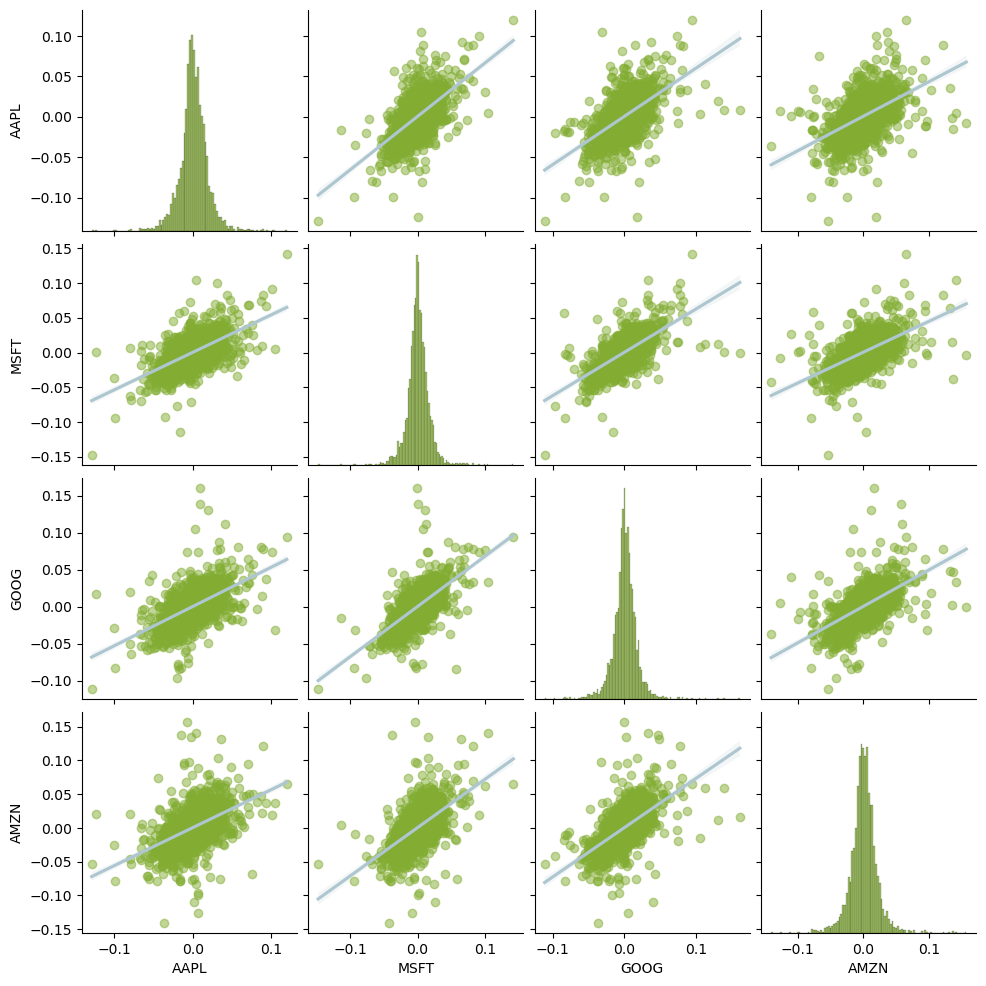

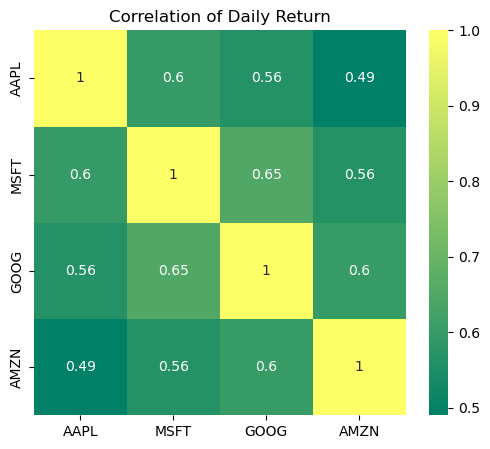

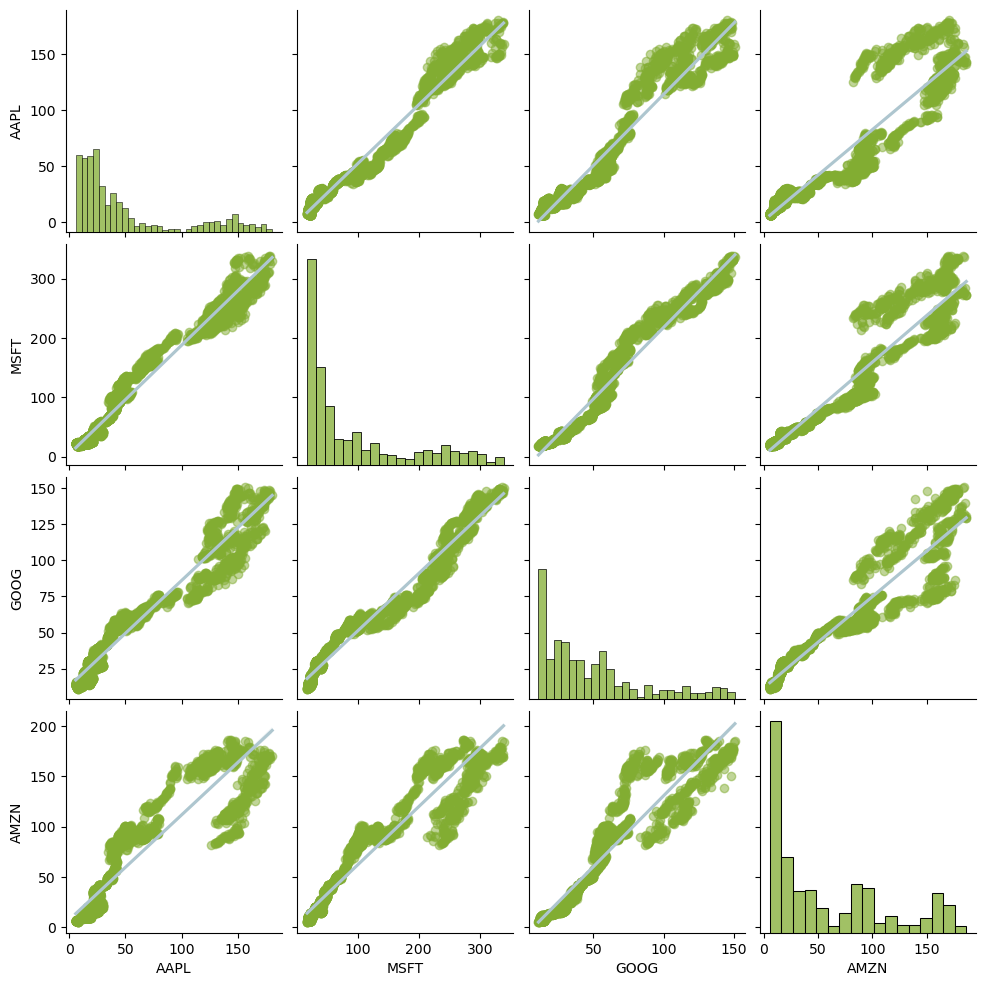

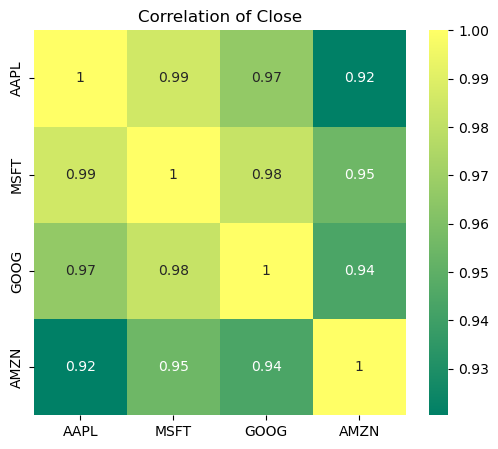

In [ ]:
#analyze correlation betweeen stock prices and stock returns

for i in ['Daily Return', 'Close']:
    df = [stock_dict[stock]['data'][['Ticker','Date',i]].rename(columns={i:stock}).drop(columns='Ticker').set_index('Date') for stock in stock_dict]
    df = pd.concat(df, axis=1)
    sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'#aec6cf'},
                                                   'scatter_kws': {'alpha': 0.5,'color': '#82ad32'}}, 
                 diag_kws= {'color': '#82ad32'})

    plt.figure(figsize = (6,5))
    sns.heatmap(df.corr(), annot=True, cmap='summer')
    plt.title(f'Correlation of {i}')
    plt.show()


In [9]:
#preprocessing and normalization
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

def model(stock, train_per, time_steps, batch_size, epochs):
    
    #preprocessing and normalization
    data = stock_dict[stock]['data'].set_index('Date')
    data = data['Close'].values.reshape(-1,1)
    
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(data)
    
    train_size = round(len(scaled_data)*train_per)
    test_size = len(scaled_data) - train_size
    train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data),:]
        
    X_train, X_test, Y_train, Y_test = [], [], [], []

    for i in range(len(train_data) - time_steps - 1):
        X_train.append(train_data[i: (i+ time_steps), 0])
        Y_train.append(train_data[(i + time_steps), 0])
        
    for i in range(len(test_data) - time_steps - 1):
        X_test.append(test_data[i: (i+ time_steps), 0])
        Y_test.append(test_data[(i + time_steps), 0])

    X_train, X_test, Y_train, Y_test = np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    #build model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam',loss='mean_squared_error')
    
    model.fit(X_train, Y_train, epochs=epochs, batch_size = batch_size)
    
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    
    rmse = np.sqrt(np.mean(((predictions - Y_test)**2)))
    print("RMSE: ", rmse)
    
    #stock prediction data visualization
    plt.figure(figsize = (16,6))

    plt.plot(stock_dict[stock]['data']['Date'],stock_dict[stock]['data']['Close'], color = 'b')
    plt.plot(stock_dict[stock]['data']['Date'].iloc[train_size+time_steps+1:], predictions, color = 'r')

    plt.title(f"{stock} Stock Price Prediction Model", fontsize = 18)
    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('Close Price USD ($)', fontsize = 12)
    plt.legend(['Actual','Predicted'])
    plt.show()


Epoch 1/5
80/80 [==============================] - 19s 102ms/step - loss: 9.2813e-04
Epoch 2/5
80/80 [==============================] - 8s 97ms/step - loss: 8.3778e-05
Epoch 3/5
80/80 [==============================] - 8s 104ms/step - loss: 7.9863e-05
Epoch 4/5
80/80 [==============================] - 8s 94ms/step - loss: 6.8651e-05
Epoch 5/5
19/19 [==============================] - 3s 35ms/step
RMSE:  134.61646166627048


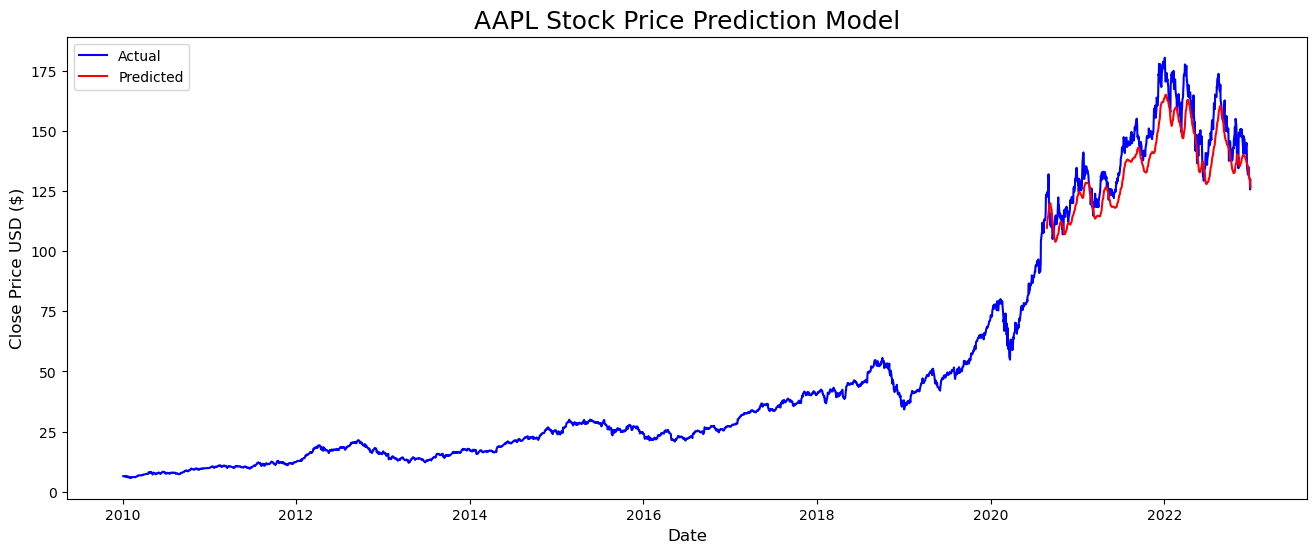

Epoch 1/5
80/80 [==============================] - 18s 94ms/step - loss: 0.0017
Epoch 2/5
80/80 [==============================] - 7s 89ms/step - loss: 6.9903e-05
Epoch 3/5
80/80 [==============================] - 7s 93ms/step - loss: 6.7802e-05
Epoch 4/5
80/80 [==============================] - 8s 99ms/step - loss: 6.4168e-05
Epoch 5/5
19/19 [==============================] - 3s 36ms/step
RMSE:  255.34007775477852


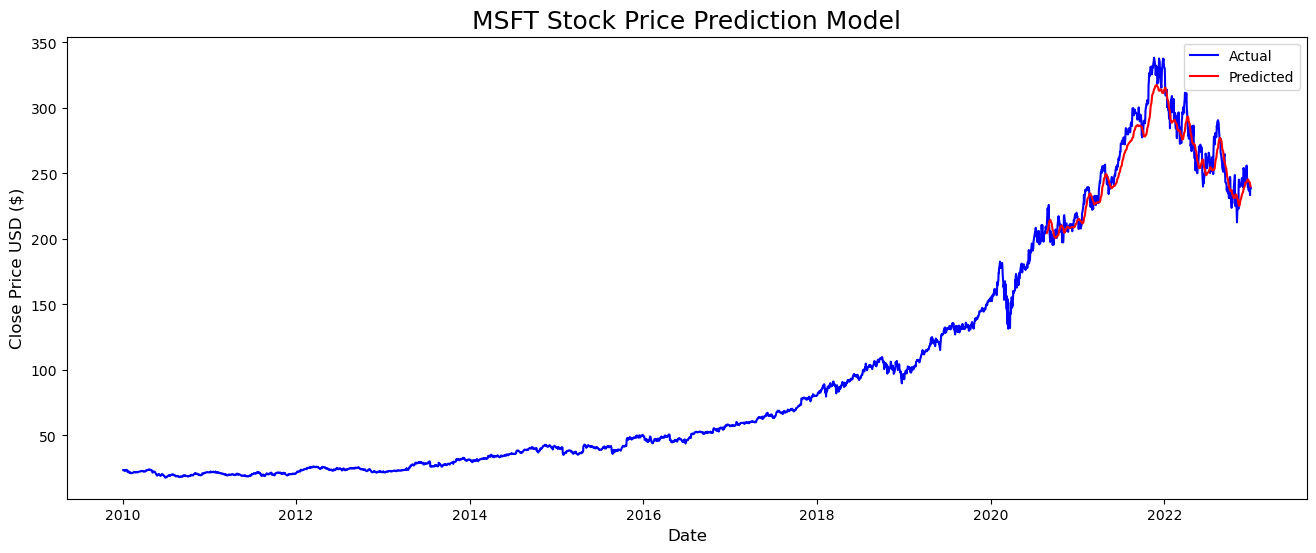

Epoch 1/5
80/80 [==============================] - 20s 109ms/step - loss: 0.0020
Epoch 2/5
80/80 [==============================] - 9s 107ms/step - loss: 1.1451e-04
Epoch 3/5
80/80 [==============================] - 9s 113ms/step - loss: 1.1599e-04
Epoch 4/5
80/80 [==============================] - 8s 105ms/step - loss: 1.0355e-04
Epoch 5/5
19/19 [==============================] - 3s 37ms/step
RMSE:  107.89837591001015


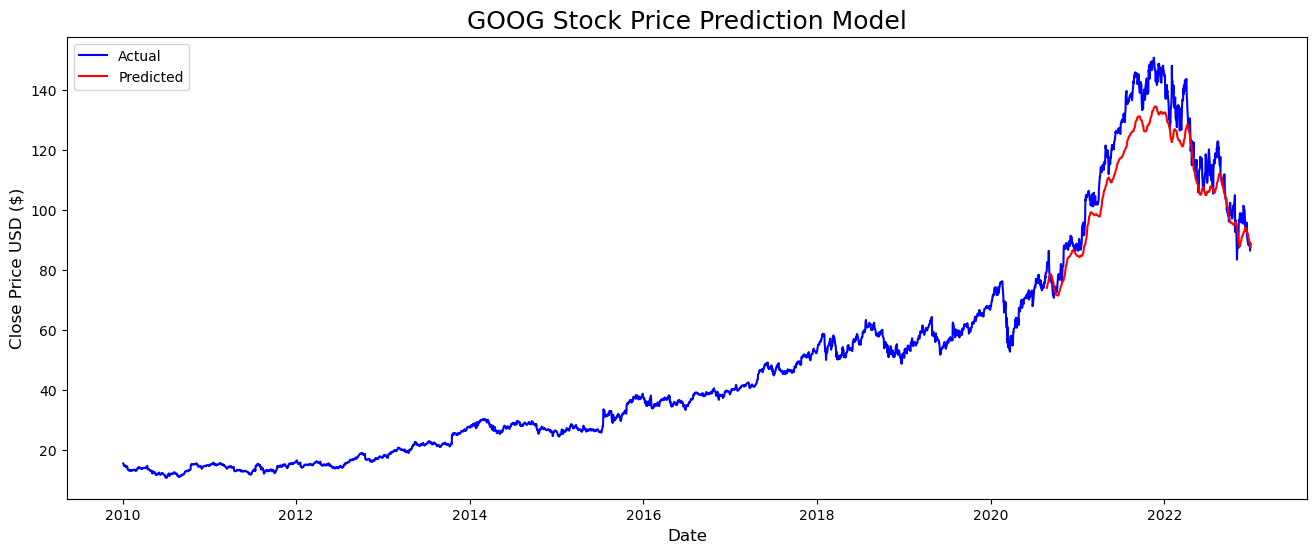

Epoch 1/5
80/80 [==============================] - 18s 93ms/step - loss: 0.0032
Epoch 2/5
80/80 [==============================] - 8s 101ms/step - loss: 1.5090e-04
Epoch 3/5
80/80 [==============================] - 7s 90ms/step - loss: 1.6124e-04
Epoch 4/5
80/80 [==============================] - 8s 103ms/step - loss: 1.5584e-04
Epoch 5/5
19/19 [==============================] - 3s 37ms/step
RMSE:  147.35596369039195


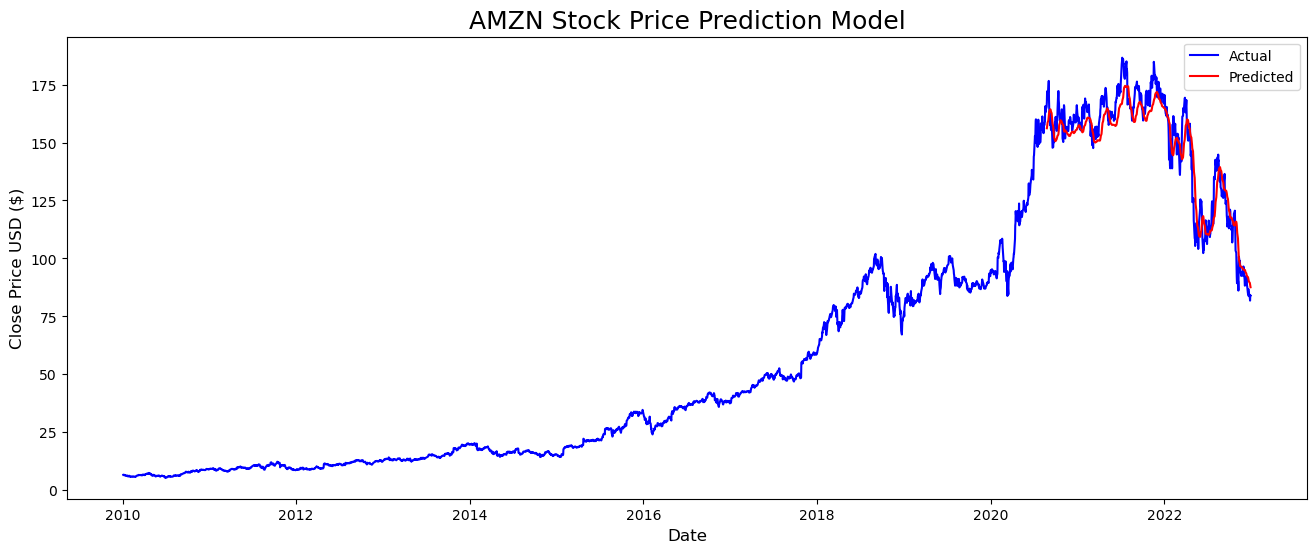

In [10]:
#inputs for stock prediction model
for stock in stock_list:
    train_per = 0.80
    timesteps = 60  
    batch_size = 32
    epochs = 5

    if stock in stock_list:
        predictions = model(stock, train_per, timesteps, batch_size, epochs)

    else:
        print("No data available for stock! Add to stock list in first cell and rerun!")